In [1]:
import os, sys, random, pandas as pd, numpy as np
from tqdm import tqdm
import torch


# set random seed
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
sys.path.append('../')


# load package requirments
from VGFM.utils import  generate_steps, parser, _valid_criterions
from VGFM.plots import plot_comparision
from VGFM.train import pretrain, train
from VGFM.models import  FNet, ODEFunc2
from VGFM.constants import DATA_DIR
from VGFM.exp import setup_exp
from VGFM.eval import generate_plot_data
from torchdiffeq import odeint_adjoint as odeint

### Defining parameters and loading dataset

In [3]:
import torch.optim as optim

dim=2
f_net = FNet(in_out_dim=dim, hidden_dim=128, n_hiddens=3, activation='leakyrelu')


import sys

# Simulate the command-line arguments
sys.argv = [
    'VGFM Training',
    '-d', 'file',
    '-c', 'ot1',
    '-n', 'Mouse_hematopoiesis_final',
    '--no-hold-one-out',
    '-ho', '-1',
    '-e1', '200',
    '-e2', '100',
    '-bs', '256',
    '-r', '0.03',
    '-rm', '10',
    '-lr2','1e-3',
    '--no-norm_cost'
]

args = parser.parse_args()
opts = vars(args)

# Display the parsed arguments
print(opts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


{'dataset': 'file', 'time_col': None, 'name': 'Mouse_hematopoiesis_final', 'output_dir': 'd:\\NeurIPS_2025_VGFM\\VGFM\\results', 'criterion': 'ot1', 'sample_with_replacement': False, 'hold_one_out': False, 'hold_out': -1, 'apply_losses_in_time': True, 'learning_rate1': 0.001, 'epochs1': 200, 'norm_cost': False, 'reg': 0.03, 'reg_m': 10.0, 'n_big_batches': 1, 'n_batch': 256, 'learning_rate2': 0.001, 'epochs2': 100}


device(type='cpu')

In [4]:
df = pd.read_csv(DATA_DIR + '/mouse_hematopoiesis.csv')
 # make output dir
if not os.path.isdir(opts['output_dir']):
    os.makedirs(opts['output_dir'])
exp_dir, logger = setup_exp(opts['output_dir'], opts, opts['name'])
  # load dataset
logger.info(f'Loading dataset: '+opts['name'])


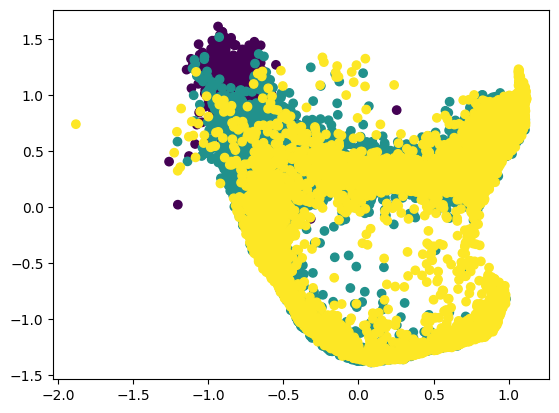

In [5]:
import matplotlib.pyplot as plt
plt.scatter(df.iloc[:,1],df.iloc[:,2],c=df.iloc[:,0])

In [6]:
groups = sorted([g for g in df.samples.unique() if g != args.hold_out])
steps = generate_steps(groups)
optimizer = torch.optim.Adam(f_net.parameters())
opts['criterion']='ot1'
criterion =  _valid_criterions[opts['criterion']]()

# # logger.info(f'Extracting parameters')
use_cuda = torch.cuda.is_available()
# sample_with_replacement = opts['sample_with_replacement' ]
# apply_losses_in_time = opts['apply_losses_in_time']

    
local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []

In [7]:
f_net=f_net.to(device)

In [8]:
initial_size=df[df['samples']==0].x1.shape[0]
initial_size

1429

In [9]:
sample_sizes = df.groupby('samples').size()
ref0 = sample_sizes / sample_sizes.iloc[0]  
relative_mass = torch.tensor(ref0.values) 
relative_mass

tensor([1.0000, 2.6459, 4.0504], dtype=torch.float64)

In [10]:
sample_size = (df[df['samples']==0.0].values.shape[0],)

### Training with $\mathcal{L}_{\rm VGFM}$

In [11]:
f_net, v_losses, g_losses, losses = pretrain(
    f_net,
    df,
    optimizer,
    n_epoch=args.epochs1,
    hold_out=args.hold_out,
    logger=logger,
    relative_mass=relative_mass,
    reg=args.reg,
    reg_m=[args.reg_m, np.inf],
    norm_cost=args.norm_cost
)


relative_mass tensor([1.0000, 2.6459, 4.0504], dtype=torch.float64)
t_train: [0, 1, 2]


Begin flow and growth matching...: 100%|██████████| 200/200 [00:08<00:00, 24.16epoch/s, loss=0.040091, vloss=0.034907, gloss=0.005183]


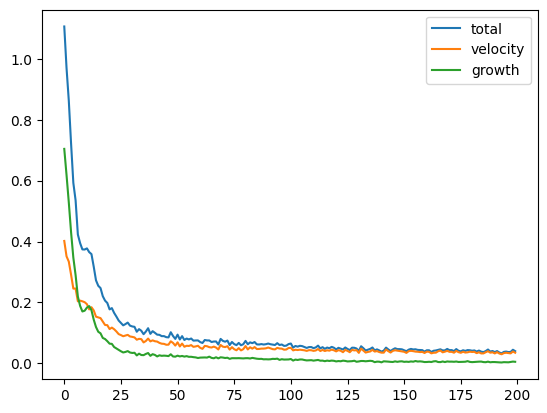

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses,label='total')
plt.plot(v_losses,label='velocity')
plt.plot(g_losses,label='growth')
plt.legend()

In [13]:
torch.save(f_net.state_dict(), os.path.join(exp_dir+'/pretrain_best_model'))

In [14]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/pretrain_best_model'),map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(f_net.parameters(),lr=args.learning_rate2)

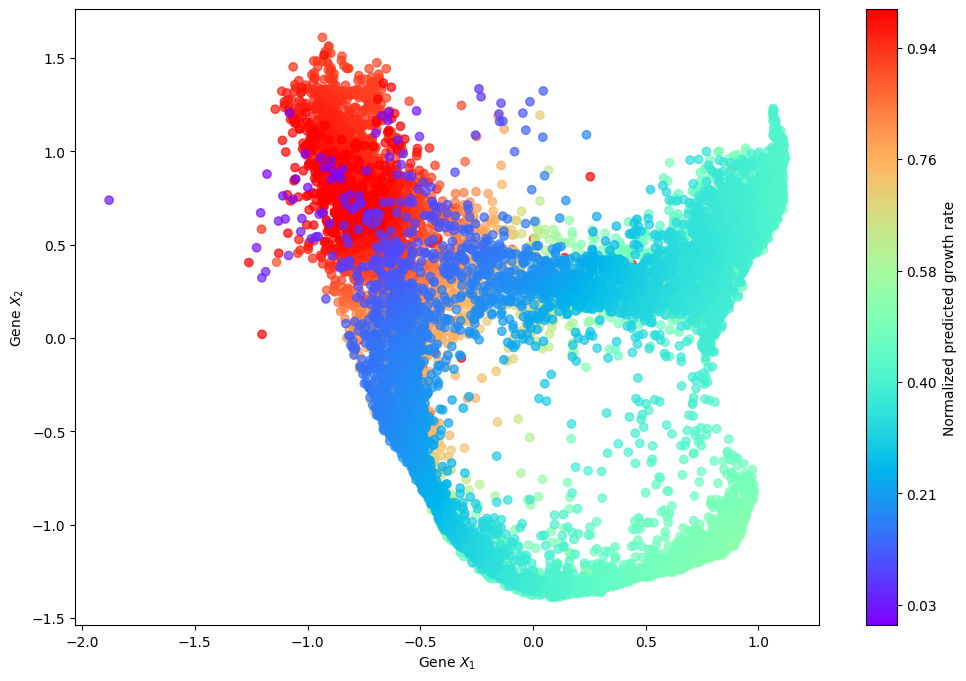

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        x = torch.tensor(subset['x1'].values, dtype=torch.float32).to(device)
        y = torch.tensor(subset['x2'].values, dtype=torch.float32).to(device)
        data = torch.stack([x, y], dim=1)
        
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 95)
    
    norm = plt.Normalize(vmin=all_g_values.min(), vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_pretrain.pdf')

In [16]:
# generate plot data
f_net.to('cpu')
generated, trajectories,_,_ = generate_plot_data(
    f_net, df, n_points=200, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0202, 0.0404, 0.0606, 0.0808, 0.1010, 0.1212, 0.1414, 0.1616,
        0.1818, 0.2020, 0.2222, 0.2424, 0.2626, 0.2828, 0.3030, 0.3232, 0.3434,
        0.3636, 0.3838, 0.4040, 0.4242, 0.4444, 0.4646, 0.4848, 0.5051, 0.5253,
        0.5455, 0.5657, 0.5859, 0.6061, 0.6263, 0.6465, 0.6667, 0.6869, 0.7071,
        0.7273, 0.7475, 0.7677, 0.7879, 0.8081, 0.8283, 0.8485, 0.8687, 0.8889,
        0.9091, 0.9293, 0.9495, 0.9697, 0.9899, 1.0101, 1.0303, 1.0505, 1.0707,
        1.0909, 1.1111, 1.1313, 1.1515, 1.1717, 1.1919, 1.2121, 1.2323, 1.2525,
        1.2727, 1.2929, 1.3131, 1.3333, 1.3535, 1.3737, 1.3939, 1.4141, 1.4343,
        1.4545, 1.4747, 1.4949, 1.5152, 1.5354, 1.5556, 1.5758, 1.5960, 1.6162,
        1.6364, 1.6566, 1.6768, 1.6970, 1.7172, 1.7374, 1.7576, 1.7778, 1.7980,
        1.8182, 1.8384, 1.8586, 1.8788, 1.8990, 1.9192, 1.9394, 1.9596, 1.9798,
        2.0000])
<class 'torch.Tensor'>


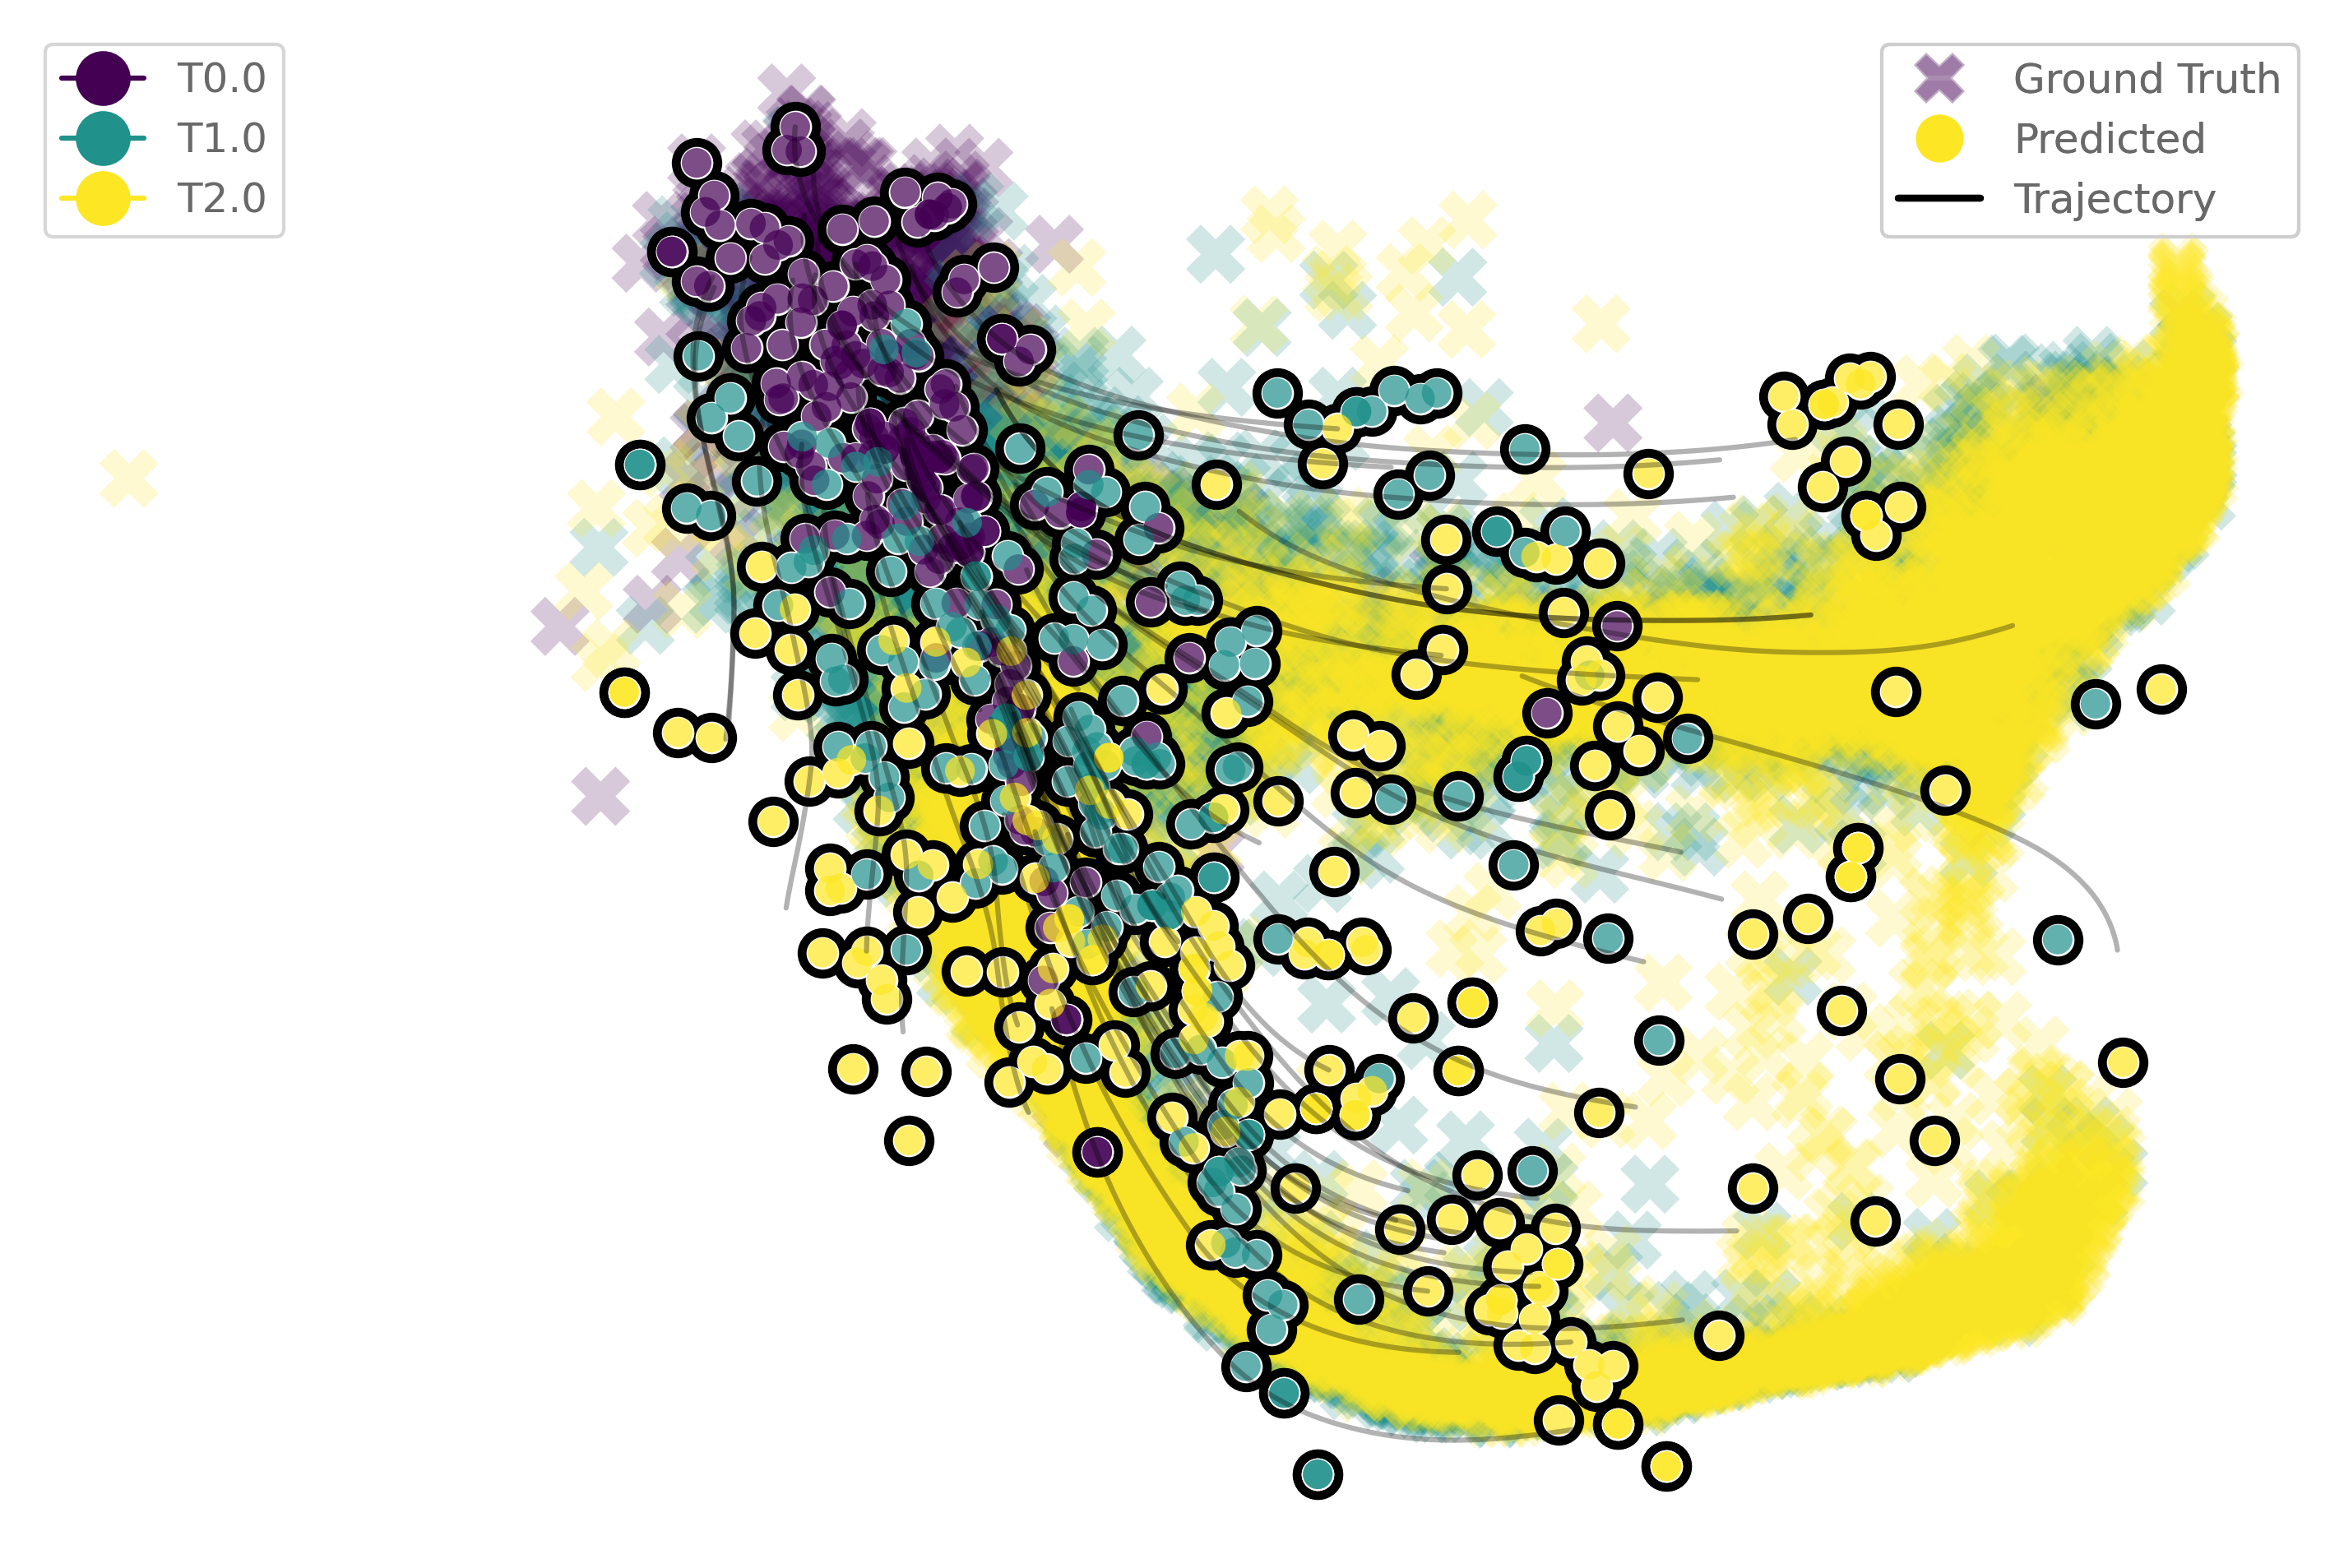

In [17]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_pretrain.png',
    x='x1', y='x2', is_3d=False
)

### Incorporating $\mathcal{L}_{\rm OT}$

In [18]:
logger.info("Incorporating $L_{ot}$")

# 训练阶段
l_loss, b_loss, g_loss = train(
    f_net,
    df,
    groups,
    optimizer,
    args.epochs2, 
    criterion=criterion,
    use_cuda=use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out,
    hold_out=args.hold_out,
    sample_size=sample_size,
    relative_mass=relative_mass,
    initial_size=initial_size,
    sample_with_replacement=args.sample_with_replacement,
    logger=logger,
    device=device,
    best_model_path=exp_dir + "/best_model",
    stepsize=0.1,
)

# 累积损失
for k, v in l_loss.items():
    local_losses[k].extend(v)

batch_losses.extend(b_loss)
globe_losses.extend(g_loss)


  0%|          | 0/100 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:2.5066161155700684,relative_mass_now:2.6459062281315604
RME:0.05264363153937374
Otloss:0.406161
total loss:0.406161
epoch_0_1:
relative_mass_pred:3.9063668251037598,relative_mass_now:4.0503848845346395
RME:0.03555663561277249


d:\NeurIPS_2025_VGFM\VGFM\notebooks\..\VGFM\train.py:200: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  batch_loss = torch.Tensor(batch_loss).float()
  1%|          | 1/100 [00:01<02:35,  1.57s/it]

Otloss:0.35634
total loss:0.35634
New minimum otloss found: 0.3563401997089386. Model saved.
epoch_1_0:
relative_mass_pred:2.507218360900879,relative_mass_now:2.6459062281315604
RME:0.05241601752780848
Otloss:0.427672
total loss:0.427672
epoch_1_1:
relative_mass_pred:4.039219379425049,relative_mass_now:4.0503848845346395
RME:0.002756652868280079


  2%|▏         | 2/100 [00:03<02:35,  1.59s/it]

Otloss:0.692903
total loss:0.692903
epoch_2_0:
relative_mass_pred:2.514472484588623,relative_mass_now:2.6459062281315604
RME:0.04967437702270761
Otloss:0.380975
total loss:0.380975
epoch_2_1:
relative_mass_pred:4.015899658203125,relative_mass_now:4.0503848845346395
RME:0.008514061580465488


  3%|▎         | 3/100 [00:04<02:28,  1.53s/it]

Otloss:0.505581
total loss:0.505581
epoch_3_0:
relative_mass_pred:2.5213894844055176,relative_mass_now:2.6459062281315604
RME:0.04706014990333647
Otloss:0.311399
total loss:0.311399
epoch_3_1:
relative_mass_pred:3.93113112449646,relative_mass_now:4.0503848845346395
RME:0.02944257482628863


  4%|▍         | 4/100 [00:06<02:28,  1.55s/it]

Otloss:0.361021
total loss:0.361021
epoch_4_0:
relative_mass_pred:2.511749744415283,relative_mass_now:2.6459062281315604
RME:0.05070341582400426
Otloss:0.353194
total loss:0.353194
epoch_4_1:
relative_mass_pred:3.8321871757507324,relative_mass_now:4.0503848845346395
RME:0.05387085795649676


  5%|▌         | 5/100 [00:07<02:31,  1.60s/it]

Otloss:0.531374
total loss:0.531374
epoch_5_0:
relative_mass_pred:2.506441593170166,relative_mass_now:2.6459062281315604
RME:0.05270959094415038
Otloss:0.346333
total loss:0.346333
epoch_5_1:
relative_mass_pred:3.837820053100586,relative_mass_now:4.0503848845346395
RME:0.05248015620581593


  6%|▌         | 6/100 [00:09<02:24,  1.54s/it]

Otloss:0.384606
total loss:0.384606
epoch_6_0:
relative_mass_pred:2.508427619934082,relative_mass_now:2.6459062281315604
RME:0.05195898733514853
Otloss:0.320682
total loss:0.320682
epoch_6_1:
relative_mass_pred:3.899679183959961,relative_mass_now:4.0503848845346395
RME:0.03720774812045883


  7%|▋         | 7/100 [00:10<02:24,  1.55s/it]

Otloss:0.405297
total loss:0.405297
epoch_7_0:
relative_mass_pred:2.514458656311035,relative_mass_now:2.6459062281315604
RME:0.04967960331434292
Otloss:0.311577
total loss:0.311577
epoch_7_1:
relative_mass_pred:3.9558162689208984,relative_mass_now:4.0503848845346395
RME:0.023348056619218384


  8%|▊         | 8/100 [00:12<02:19,  1.51s/it]

Otloss:0.391134
total loss:0.391134
epoch_8_0:
relative_mass_pred:2.5225276947021484,relative_mass_now:2.6459062281315604
RME:0.04662997203666482
Otloss:0.311412
total loss:0.311412
epoch_8_1:
relative_mass_pred:3.9921462535858154,relative_mass_now:4.0503848845346395
RME:0.01437854243708874


  9%|▉         | 9/100 [00:13<02:17,  1.51s/it]

Otloss:0.367891
total loss:0.367891
epoch_9_0:
relative_mass_pred:2.525050640106201,relative_mass_now:2.6459062281315604
RME:0.04567644413865071
Otloss:0.310316
total loss:0.310316
epoch_9_1:
relative_mass_pred:3.9849953651428223,relative_mass_now:4.0503848845346395
RME:0.01614402612489752


 10%|█         | 10/100 [00:15<02:19,  1.55s/it]

Otloss:0.361202
total loss:0.361202
epoch_10_0:
relative_mass_pred:2.518937110900879,relative_mass_now:2.6459062281315604
RME:0.047987005692315225
Otloss:0.274471
total loss:0.274471
epoch_10_1:
relative_mass_pred:3.9369590282440186,relative_mass_now:4.0503848845346395
RME:0.02800372298536582


 11%|█         | 11/100 [00:16<02:15,  1.52s/it]

Otloss:0.271865
total loss:0.271865
New minimum otloss found: 0.2718648314476013. Model saved.
epoch_11_0:
relative_mass_pred:2.5080666542053223,relative_mass_now:2.6459062281315604
RME:0.05209541156852534
Otloss:0.258635
total loss:0.258635
epoch_11_1:
relative_mass_pred:3.8924825191497803,relative_mass_now:4.0503848845346395
RME:0.038984533540940544


 12%|█▏        | 12/100 [00:18<02:08,  1.46s/it]

Otloss:0.220732
total loss:0.220732
New minimum otloss found: 0.22073228657245636. Model saved.
epoch_12_0:
relative_mass_pred:2.501025676727295,relative_mass_now:2.6459062281315604
RME:0.0547564950956613
Otloss:0.263849
total loss:0.263849
epoch_12_1:
relative_mass_pred:3.902926445007324,relative_mass_now:4.0503848845346395
RME:0.03640603145897263


 13%|█▎        | 13/100 [00:19<02:08,  1.48s/it]

Otloss:0.312979
total loss:0.312979
epoch_13_0:
relative_mass_pred:2.5013136863708496,relative_mass_now:2.6459062281315604
RME:0.05464764405608456
Otloss:0.237699
total loss:0.237699
epoch_13_1:
relative_mass_pred:3.9283547401428223,relative_mass_now:4.0503848845346395
RME:0.030128036685540233


 14%|█▍        | 14/100 [00:21<02:09,  1.51s/it]

Otloss:0.330948
total loss:0.330948
epoch_14_0:
relative_mass_pred:2.506709575653076,relative_mass_now:2.6459062281315604
RME:0.05260830901659719
Otloss:0.20475
total loss:0.20475
epoch_14_1:
relative_mass_pred:3.929349184036255,relative_mass_now:4.0503848845346395
RME:0.029882518315858957


 15%|█▌        | 15/100 [00:22<02:05,  1.48s/it]

Otloss:0.220825
total loss:0.220825
epoch_15_0:
relative_mass_pred:2.5104501247406006,relative_mass_now:2.6459062281315604
RME:0.05119459712924665
Otloss:0.220443
total loss:0.220443
epoch_15_1:
relative_mass_pred:3.9325180053710938,relative_mass_now:4.0503848845346395
RME:0.029100167644213356


 16%|█▌        | 16/100 [00:24<02:01,  1.45s/it]

Otloss:0.256021
total loss:0.256021
epoch_16_0:
relative_mass_pred:2.5100255012512207,relative_mass_now:2.6459062281315604
RME:0.051355080325841164
Otloss:0.195443
total loss:0.195443
epoch_16_1:
relative_mass_pred:3.9628891944885254,relative_mass_now:4.0503848845346395
RME:0.02160182119486819


 17%|█▋        | 17/100 [00:25<01:59,  1.44s/it]

Otloss:0.244318
total loss:0.244318
epoch_17_0:
relative_mass_pred:2.5042927265167236,relative_mass_now:2.6459062281315604
RME:0.05352173864258179
Otloss:0.184328
total loss:0.184328
epoch_17_1:
relative_mass_pred:3.956634044647217,relative_mass_now:4.0503848845346395
RME:0.023146155874071712


 18%|█▊        | 18/100 [00:26<01:57,  1.43s/it]

Otloss:0.261665
total loss:0.261665
epoch_18_0:
relative_mass_pred:2.499788761138916,relative_mass_now:2.6459062281315604
RME:0.05522397787159186
Otloss:0.195072
total loss:0.195072
epoch_18_1:
relative_mass_pred:3.904836416244507,relative_mass_now:4.0503848845346395
RME:0.03593447843583269


 19%|█▉        | 19/100 [00:28<01:55,  1.42s/it]

Otloss:0.19495
total loss:0.19495
New minimum otloss found: 0.1949501782655716. Model saved.
epoch_19_0:
relative_mass_pred:2.500288963317871,relative_mass_now:2.6459062281315604
RME:0.055034930287956106
Otloss:0.190061
total loss:0.190061
epoch_19_1:
relative_mass_pred:3.903779983520508,relative_mass_now:4.0503848845346395
RME:0.036195301235175226


 20%|██        | 20/100 [00:29<01:52,  1.41s/it]

Otloss:0.18638
total loss:0.18638
New minimum otloss found: 0.18637950718402863. Model saved.
epoch_20_0:
relative_mass_pred:2.504455804824829,relative_mass_now:2.6459062281315604
RME:0.053460104444675756
Otloss:0.17501
total loss:0.17501
epoch_20_1:
relative_mass_pred:3.9546823501586914,relative_mass_now:4.0503848845346395
RME:0.0236280099556375


 21%|██        | 21/100 [00:31<01:49,  1.38s/it]

Otloss:0.199738
total loss:0.199738
epoch_21_0:
relative_mass_pred:2.5089235305786133,relative_mass_now:2.6459062281315604
RME:0.051771561704089246
Otloss:0.170914
total loss:0.170914
epoch_21_1:
relative_mass_pred:3.9497079849243164,relative_mass_now:4.0503848845346395
RME:0.02485613157276291


 22%|██▏       | 22/100 [00:32<01:47,  1.38s/it]

Otloss:0.1782
total loss:0.1782
New minimum otloss found: 0.1782001256942749. Model saved.
epoch_22_0:
relative_mass_pred:2.5073890686035156,relative_mass_now:2.6459062281315604
RME:0.05235149985865538
Otloss:0.174269
total loss:0.174269
epoch_22_1:
relative_mass_pred:3.9078760147094727,relative_mass_now:4.0503848845346395
RME:0.035184031613711725


 23%|██▎       | 23/100 [00:33<01:48,  1.41s/it]

Otloss:0.241422
total loss:0.241422
epoch_23_0:
relative_mass_pred:2.503551483154297,relative_mass_now:2.6459062281315604
RME:0.05380188589592954
Otloss:0.144588
total loss:0.144588
epoch_23_1:
relative_mass_pred:3.9186763763427734,relative_mass_now:4.0503848845346395
RME:0.03251752906119154


 24%|██▍       | 24/100 [00:35<01:43,  1.36s/it]

Otloss:0.148117
total loss:0.148117
New minimum otloss found: 0.14811678230762482. Model saved.
epoch_24_0:
relative_mass_pred:2.5001654624938965,relative_mass_now:2.6459062281315604
RME:0.05508160647876798
Otloss:0.164843
total loss:0.164843
epoch_24_1:
relative_mass_pred:3.9359352588653564,relative_mass_now:4.0503848845346395
RME:0.02825648152754069


 25%|██▌       | 25/100 [00:36<01:45,  1.41s/it]

Otloss:0.218221
total loss:0.218221
epoch_25_0:
relative_mass_pred:2.5022940635681152,relative_mass_now:2.6459062281315604
RME:0.054277118000836594
Otloss:0.140726
total loss:0.140726
epoch_25_1:
relative_mass_pred:3.9157330989837646,relative_mass_now:4.0503848845346395
RME:0.03324419515414654


 26%|██▌       | 26/100 [00:38<01:42,  1.38s/it]

Otloss:0.141775
total loss:0.141775
New minimum otloss found: 0.14177526533603668. Model saved.
epoch_26_0:
relative_mass_pred:2.5060923099517822,relative_mass_now:2.6459062281315604
RME:0.052841599862180115
Otloss:0.136986
total loss:0.136986
epoch_26_1:
relative_mass_pred:3.941371202468872,relative_mass_now:4.0503848845346395
RME:0.02691440077262987


 27%|██▋       | 27/100 [00:39<01:39,  1.36s/it]

Otloss:0.147654
total loss:0.147654
epoch_27_0:
relative_mass_pred:2.5063107013702393,relative_mass_now:2.6459062281315604
RME:0.05275906049773285
Otloss:0.145633
total loss:0.145633
epoch_27_1:
relative_mass_pred:3.969728946685791,relative_mass_now:4.0503848845346395
RME:0.019913153971320752


 28%|██▊       | 28/100 [00:40<01:38,  1.37s/it]

Otloss:0.167973
total loss:0.167973
epoch_28_0:
relative_mass_pred:2.5030126571655273,relative_mass_now:2.6459062281315604
RME:0.05400553105275357
Otloss:0.120202
total loss:0.120202
epoch_28_1:
relative_mass_pred:3.924021005630493,relative_mass_now:4.0503848845346395
RME:0.03119799290843558


 29%|██▉       | 29/100 [00:41<01:34,  1.33s/it]

Otloss:0.105692
total loss:0.105692
New minimum otloss found: 0.10569211840629578. Model saved.
epoch_29_0:
relative_mass_pred:2.4995994567871094,relative_mass_now:2.6459062281315604
RME:0.055295524001909686
Otloss:0.147203
total loss:0.147203
epoch_29_1:
relative_mass_pred:3.8971848487854004,relative_mass_now:4.0503848845346395
RME:0.03782357482475168


 30%|███       | 30/100 [00:43<01:34,  1.34s/it]

Otloss:0.151382
total loss:0.151382
epoch_30_0:
relative_mass_pred:2.5005626678466797,relative_mass_now:2.6459062281315604
RME:0.054931485756967616
Otloss:0.150236
total loss:0.150236
epoch_30_1:
relative_mass_pred:3.946331024169922,relative_mass_now:4.0503848845346395
RME:0.025689869810155756


 31%|███       | 31/100 [00:44<01:33,  1.36s/it]

Otloss:0.179687
total loss:0.179687
epoch_31_0:
relative_mass_pred:2.5055837631225586,relative_mass_now:2.6459062281315604
RME:0.05303380124249235
Otloss:0.112887
total loss:0.112887
epoch_31_1:
relative_mass_pred:3.9378013610839844,relative_mass_now:4.0503848845346395
RME:0.02779575933154565


 32%|███▏      | 32/100 [00:46<01:31,  1.34s/it]

Otloss:0.109534
total loss:0.109534
epoch_32_0:
relative_mass_pred:2.506000518798828,relative_mass_now:2.6459062281315604
RME:0.05287629162562138
Otloss:0.14491
total loss:0.14491
epoch_32_1:
relative_mass_pred:3.920900583267212,relative_mass_now:4.0503848845346395
RME:0.031968394352307195


 33%|███▎      | 33/100 [00:47<01:32,  1.39s/it]

Otloss:0.176269
total loss:0.176269
epoch_33_0:
relative_mass_pred:2.5043020248413086,relative_mass_now:2.6459062281315604
RME:0.05351822441199943
Otloss:0.107964
total loss:0.107964
epoch_33_1:
relative_mass_pred:3.9522476196289062,relative_mass_now:4.0503848845346395
RME:0.024229120862179137


 34%|███▍      | 34/100 [00:48<01:28,  1.33s/it]

Otloss:0.142739
total loss:0.142739
epoch_34_0:
relative_mass_pred:2.500532627105713,relative_mass_now:2.6459062281315604
RME:0.054942839425002936
Otloss:0.116019
total loss:0.116019
epoch_34_1:
relative_mass_pred:3.936920404434204,relative_mass_now:4.0503848845346395
RME:0.028013258822308606


 35%|███▌      | 35/100 [00:50<01:25,  1.32s/it]

Otloss:0.158656
total loss:0.158656
epoch_35_0:
relative_mass_pred:2.4997832775115967,relative_mass_now:2.6459062281315604
RME:0.05522605036655069
Otloss:0.152495
total loss:0.152495
epoch_35_1:
relative_mass_pred:3.897918701171875,relative_mass_now:4.0503848845346395
RME:0.03764239392283872


 36%|███▌      | 36/100 [00:51<01:27,  1.37s/it]

Otloss:0.164295
total loss:0.164295
epoch_36_0:
relative_mass_pred:2.503602981567383,relative_mass_now:2.6459062281315604
RME:0.053782422465011845
Otloss:0.09691
total loss:0.09691
epoch_36_1:
relative_mass_pred:3.9358253479003906,relative_mass_now:4.0503848845346395
RME:0.02828361745859393


 37%|███▋      | 37/100 [00:52<01:22,  1.32s/it]

Otloss:0.0897462
total loss:0.0897462
New minimum otloss found: 0.08974621444940567. Model saved.
epoch_37_0:
relative_mass_pred:2.5040106773376465,relative_mass_now:2.6459062281315604
RME:0.05362833697024676
Otloss:0.177413
total loss:0.177413
epoch_37_1:
relative_mass_pred:3.9762377738952637,relative_mass_now:4.0503848845346395
RME:0.018306188856888058


 38%|███▊      | 38/100 [00:54<01:24,  1.36s/it]

Otloss:0.201954
total loss:0.201954
epoch_38_0:
relative_mass_pred:2.5038256645202637,relative_mass_now:2.6459062281315604
RME:0.053698261147988105
Otloss:0.0990379
total loss:0.0990379
epoch_38_1:
relative_mass_pred:3.9200916290283203,relative_mass_now:4.0503848845346395
RME:0.03216811715938669


 39%|███▉      | 39/100 [00:55<01:21,  1.33s/it]

Otloss:0.116077
total loss:0.116077
epoch_39_0:
relative_mass_pred:2.4994759559631348,relative_mass_now:2.6459062281315604
RME:0.05534220019272157
Otloss:0.147516
total loss:0.147516
epoch_39_1:
relative_mass_pred:3.8850655555725098,relative_mass_now:4.0503848845346395
RME:0.04081570854991075


 40%|████      | 40/100 [00:56<01:21,  1.35s/it]

Otloss:0.178025
total loss:0.178025
epoch_40_0:
relative_mass_pred:2.4992504119873047,relative_mass_now:2.6459062281315604
RME:0.05542744281146295
Otloss:0.114489
total loss:0.114489
epoch_40_1:
relative_mass_pred:3.929321765899658,relative_mass_now:4.0503848845346395
RME:0.02988928758282452


 41%|████      | 41/100 [00:58<01:20,  1.37s/it]

Otloss:0.168435
total loss:0.168435
epoch_41_0:
relative_mass_pred:2.5025534629821777,relative_mass_now:2.6459062281315604
RME:0.05417907997843635
Otloss:0.0994464
total loss:0.0994464
epoch_41_1:
relative_mass_pred:3.9418225288391113,relative_mass_now:4.0503848845346395
RME:0.026802972752057667


 42%|████▏     | 42/100 [00:59<01:16,  1.32s/it]

Otloss:0.117445
total loss:0.117445
epoch_42_0:
relative_mass_pred:2.505323886871338,relative_mass_now:2.6459062281315604
RME:0.05313201948184554
Otloss:0.140231
total loss:0.140231
epoch_42_1:
relative_mass_pred:3.91689133644104,relative_mass_now:4.0503848845346395
RME:0.03295823777224493


 43%|████▎     | 43/100 [01:01<01:19,  1.40s/it]

Otloss:0.198436
total loss:0.198436
epoch_43_0:
relative_mass_pred:2.5062904357910156,relative_mass_now:2.6459062281315604
RME:0.05276671971823287
Otloss:0.116843
total loss:0.116843
epoch_43_1:
relative_mass_pred:3.932889938354492,relative_mass_now:4.0503848845346395
RME:0.029008341066245773


 44%|████▍     | 44/100 [01:02<01:18,  1.40s/it]

Otloss:0.137887
total loss:0.137887
epoch_44_0:
relative_mass_pred:2.5025699138641357,relative_mass_now:2.6459062281315604
RME:0.05417286249355986
Otloss:0.12475
total loss:0.12475
epoch_44_1:
relative_mass_pred:3.9531655311584473,relative_mass_now:4.0503848845346395
RME:0.024002497576810423


 45%|████▌     | 45/100 [01:03<01:16,  1.38s/it]

Otloss:0.184354
total loss:0.184354
epoch_45_0:
relative_mass_pred:2.4997212886810303,relative_mass_now:2.6459062281315604
RME:0.0552494785704331
Otloss:0.0997299
total loss:0.0997299
epoch_45_1:
relative_mass_pred:3.9165244102478027,relative_mass_now:4.0503848845346395
RME:0.03304882822320141


 46%|████▌     | 46/100 [01:05<01:13,  1.36s/it]

Otloss:0.122891
total loss:0.122891
epoch_46_0:
relative_mass_pred:2.5003662109375,relative_mass_now:2.6459062281315604
RME:0.05500573514157956
Otloss:0.142018
total loss:0.142018
epoch_46_1:
relative_mass_pred:3.889033555984497,relative_mass_now:4.0503848845346395
RME:0.039836048462016854


 47%|████▋     | 47/100 [01:06<01:13,  1.40s/it]

Otloss:0.174017
total loss:0.174017
epoch_47_0:
relative_mass_pred:2.5052566528320312,relative_mass_now:2.6459062281315604
RME:0.053157430072210306
Otloss:0.0900017
total loss:0.0900017
epoch_47_1:
relative_mass_pred:3.93118953704834,relative_mass_now:4.0503848845346395
RME:0.02942815334449244


 48%|████▊     | 48/100 [01:07<01:12,  1.39s/it]

Otloss:0.105879
total loss:0.105879
epoch_48_0:
relative_mass_pred:2.504786252975464,relative_mass_now:2.6459062281315604
RME:0.05333521409628721
Otloss:0.153571
total loss:0.153571
epoch_48_1:
relative_mass_pred:3.968428611755371,relative_mass_now:4.0503848845346395
RME:0.020234193815061263


 49%|████▉     | 49/100 [01:09<01:11,  1.41s/it]

Otloss:0.190761
total loss:0.190761
epoch_49_0:
relative_mass_pred:2.5025696754455566,relative_mass_now:2.6459062281315604
RME:0.054172952602036334
Otloss:0.0830144
total loss:0.0830144
epoch_49_1:
relative_mass_pred:3.9266774654388428,relative_mass_now:4.0503848845346395
RME:0.030542139234259424


 50%|█████     | 50/100 [01:10<01:07,  1.35s/it]

Otloss:0.0884759
total loss:0.0884759
New minimum otloss found: 0.08847587555646896. Model saved.
epoch_50_0:
relative_mass_pred:2.4991581439971924,relative_mass_now:2.6459062281315604
RME:0.055462314791857155
Otloss:0.166448
total loss:0.166448
epoch_50_1:
relative_mass_pred:3.8743603229522705,relative_mass_now:4.0503848845346395
RME:0.04345872468921999


 51%|█████     | 51/100 [01:12<01:08,  1.40s/it]

Otloss:0.219057
total loss:0.219057
epoch_51_0:
relative_mass_pred:2.50087571144104,relative_mass_now:2.6459062281315604
RME:0.05481317332736144
Otloss:0.126542
total loss:0.126542
epoch_51_1:
relative_mass_pred:3.8997561931610107,relative_mass_now:4.0503848845346395
RME:0.037188735309764256


 52%|█████▏    | 52/100 [01:13<01:07,  1.40s/it]

Otloss:0.129166
total loss:0.129166
epoch_52_0:
relative_mass_pred:2.5042591094970703,relative_mass_now:2.6459062281315604
RME:0.05353444393776417
Otloss:0.142238
total loss:0.142238
epoch_52_1:
relative_mass_pred:3.9698572158813477,relative_mass_now:4.0503848845346395
RME:0.019881485574560136


 53%|█████▎    | 53/100 [01:14<01:06,  1.41s/it]

Otloss:0.218245
total loss:0.218245
epoch_53_0:
relative_mass_pred:2.505922317504883,relative_mass_now:2.6459062281315604
RME:0.05290584720590381
Otloss:0.141019
total loss:0.141019
epoch_53_1:
relative_mass_pred:3.965965747833252,relative_mass_now:4.0503848845346395
RME:0.020842250578141472


 54%|█████▍    | 54/100 [01:16<01:04,  1.41s/it]

Otloss:0.181686
total loss:0.181686
epoch_54_0:
relative_mass_pred:2.5044705867767334,relative_mass_now:2.6459062281315604
RME:0.053454517719134564
Otloss:0.108799
total loss:0.108799
epoch_54_1:
relative_mass_pred:3.906717300415039,relative_mass_now:4.0503848845346395
RME:0.03547010672199535


 55%|█████▌    | 55/100 [01:17<01:03,  1.40s/it]

Otloss:0.145192
total loss:0.145192
epoch_55_0:
relative_mass_pred:2.501903533935547,relative_mass_now:2.6459062281315604
RME:0.05442471568529578
Otloss:0.14694
total loss:0.14694
epoch_55_1:
relative_mass_pred:3.8891735076904297,relative_mass_now:4.0503848845346395
RME:0.039801495768897


 56%|█████▌    | 56/100 [01:19<01:02,  1.42s/it]

Otloss:0.171151
total loss:0.171151
epoch_56_0:
relative_mass_pred:2.502551555633545,relative_mass_now:2.6459062281315604
RME:0.05417980084624811
Otloss:0.0857565
total loss:0.0857565
epoch_56_1:
relative_mass_pred:3.923813819885254,relative_mass_now:4.0503848845346395
RME:0.031249145021418807


 57%|█████▋    | 57/100 [01:20<00:57,  1.35s/it]

Otloss:0.0916248
total loss:0.0916248
epoch_57_0:
relative_mass_pred:2.5034117698669434,relative_mass_now:2.6459062281315604
RME:0.05385468946314143
Otloss:0.109682
total loss:0.109682
epoch_57_1:
relative_mass_pred:3.9509196281433105,relative_mass_now:4.0503848845346395
RME:0.02455698883607621


 58%|█████▊    | 58/100 [01:21<00:56,  1.35s/it]

Otloss:0.153157
total loss:0.153157
epoch_58_0:
relative_mass_pred:2.5046486854553223,relative_mass_now:2.6459062281315604
RME:0.05338720668721087
Otloss:0.081674
total loss:0.081674
epoch_58_1:
relative_mass_pred:3.9294443130493164,relative_mass_now:4.0503848845346395
RME:0.02985903190264802


 59%|█████▉    | 59/100 [01:23<00:54,  1.33s/it]

Otloss:0.0928083
total loss:0.0928083
epoch_59_0:
relative_mass_pred:2.5009968280792236,relative_mass_now:2.6459062281315604
RME:0.05476739822131427
Otloss:0.115603
total loss:0.115603
epoch_59_1:
relative_mass_pred:3.898283004760742,relative_mass_now:4.0503848845346395
RME:0.03755245096698329


 60%|██████    | 60/100 [01:24<00:53,  1.34s/it]

Otloss:0.131163
total loss:0.131163
epoch_60_0:
relative_mass_pred:2.499281883239746,relative_mass_now:2.6459062281315604
RME:0.05541554849256881
Otloss:0.0762816
total loss:0.0762816
epoch_60_1:
relative_mass_pred:3.918148994445801,relative_mass_now:4.0503848845346395
RME:0.03264773443969429


 61%|██████    | 61/100 [01:25<00:51,  1.32s/it]

Otloss:0.0975984
total loss:0.0975984
epoch_61_0:
relative_mass_pred:2.5006728172302246,relative_mass_now:2.6459062281315604
RME:0.0548898556408381
Otloss:0.0985024
total loss:0.0985024
epoch_61_1:
relative_mass_pred:3.9391016960144043,relative_mass_now:4.0503848845346395
RME:0.027474719487805138


 62%|██████▏   | 62/100 [01:26<00:50,  1.33s/it]

Otloss:0.126099
total loss:0.126099
epoch_62_0:
relative_mass_pred:2.503276824951172,relative_mass_now:2.6459062281315604
RME:0.05390569086082391
Otloss:0.0808377
total loss:0.0808377
epoch_62_1:
relative_mass_pred:3.920184373855591,relative_mass_now:4.0503848845346395
RME:0.032145219378085794


 63%|██████▎   | 63/100 [01:28<00:49,  1.33s/it]

Otloss:0.109661
total loss:0.109661
epoch_63_0:
relative_mass_pred:2.5026750564575195,relative_mass_now:2.6459062281315604
RME:0.05413312465543624
Otloss:0.0889695
total loss:0.0889695
epoch_63_1:
relative_mass_pred:3.9125704765319824,relative_mass_now:4.0503848845346395
RME:0.03402501538282602


 64%|██████▍   | 64/100 [01:29<00:47,  1.33s/it]

Otloss:0.114045
total loss:0.114045
epoch_64_0:
relative_mass_pred:2.501260757446289,relative_mass_now:2.6459062281315604
RME:0.05466764813786108
Otloss:0.0835056
total loss:0.0835056
epoch_64_1:
relative_mass_pred:3.9298195838928223,relative_mass_now:4.0503848845346395
RME:0.029766381240006367


 65%|██████▌   | 65/100 [01:30<00:45,  1.31s/it]

Otloss:0.10832
total loss:0.10832
epoch_65_0:
relative_mass_pred:2.5006532669067383,relative_mass_now:2.6459062281315604
RME:0.054897244535908704
Otloss:0.0745951
total loss:0.0745951
epoch_65_1:
relative_mass_pred:3.9192328453063965,relative_mass_now:4.0503848845346395
RME:0.0323801423733862


 66%|██████▌   | 66/100 [01:32<00:43,  1.27s/it]

Otloss:0.0857429
total loss:0.0857429
New minimum otloss found: 0.08574294298887253. Model saved.
epoch_66_0:
relative_mass_pred:2.5016989707946777,relative_mass_now:2.6459062281315604
RME:0.05450202875810773
Otloss:0.0971251
total loss:0.0971251
epoch_66_1:
relative_mass_pred:3.9050161838531494,relative_mass_now:4.0503848845346395
RME:0.03589009558981503


 67%|██████▋   | 67/100 [01:33<00:42,  1.30s/it]

Otloss:0.134536
total loss:0.134536
epoch_67_0:
relative_mass_pred:2.50429630279541,relative_mass_now:2.6459062281315604
RME:0.053520387015434726
Otloss:0.0738987
total loss:0.0738987
epoch_67_1:
relative_mass_pred:3.9323060512542725,relative_mass_now:4.0503848845346395
RME:0.029152497021016677


 68%|██████▊   | 68/100 [01:34<00:41,  1.29s/it]

Otloss:0.0958925
total loss:0.0958925
epoch_68_0:
relative_mass_pred:2.5019021034240723,relative_mass_now:2.6459062281315604
RME:0.0544252563361546
Otloss:0.0898599
total loss:0.0898599
epoch_68_1:
relative_mass_pred:3.9381587505340576,relative_mass_now:4.0503848845346395
RME:0.02770752340822936


 69%|██████▉   | 69/100 [01:36<00:40,  1.30s/it]

Otloss:0.114276
total loss:0.114276
epoch_69_0:
relative_mass_pred:2.4992618560791016,relative_mass_now:2.6459062281315604
RME:0.055423117604592356
Otloss:0.0778548
total loss:0.0778548
epoch_69_1:
relative_mass_pred:3.905460834503174,relative_mass_now:4.0503848845346395
RME:0.03578031573859096


 70%|███████   | 70/100 [01:37<00:38,  1.30s/it]

Otloss:0.100424
total loss:0.100424
epoch_70_0:
relative_mass_pred:2.501351833343506,relative_mass_now:2.6459062281315604
RME:0.054633226699849234
Otloss:0.071076
total loss:0.071076
epoch_70_1:
relative_mass_pred:3.914613723754883,relative_mass_now:4.0503848845346395
RME:0.033520557835914365


 71%|███████   | 71/100 [01:38<00:36,  1.26s/it]

Otloss:0.0837295
total loss:0.0837295
New minimum otloss found: 0.08372951298952103. Model saved.
epoch_71_0:
relative_mass_pred:2.504802703857422,relative_mass_now:2.6459062281315604
RME:0.05332899661141073
Otloss:0.0959799
total loss:0.0959799
epoch_71_1:
relative_mass_pred:3.949697256088257,relative_mass_now:4.0503848845346395
RME:0.02485878041635813


 72%|███████▏  | 72/100 [01:39<00:35,  1.28s/it]

Otloss:0.111895
total loss:0.111895
epoch_72_0:
relative_mass_pred:2.50350284576416,relative_mass_now:2.6459062281315604
RME:0.05382026802512958
Otloss:0.0647935
total loss:0.0647935
epoch_72_1:
relative_mass_pred:3.925967216491699,relative_mass_now:4.0503848845346395
RME:0.030717492680262904


 73%|███████▎  | 73/100 [01:40<00:33,  1.23s/it]

Otloss:0.0679798
total loss:0.0679798
New minimum otloss found: 0.06797977536916733. Model saved.
epoch_73_0:
relative_mass_pred:2.4991183280944824,relative_mass_now:2.6459062281315604
RME:0.05547736290742778
Otloss:0.105214
total loss:0.105214
epoch_73_1:
relative_mass_pred:3.8915414810180664,relative_mass_now:4.0503848845346395
RME:0.03921686655583673


 74%|███████▍  | 74/100 [01:42<00:32,  1.27s/it]

Otloss:0.134495
total loss:0.134495
epoch_74_0:
relative_mass_pred:2.4999303817749023,relative_mass_now:2.6459062281315604
RME:0.0551704534365682
Otloss:0.0682185
total loss:0.0682185
epoch_74_1:
relative_mass_pred:3.9169540405273438,relative_mass_now:4.0503848845346395
RME:0.03294275675301065


 75%|███████▌  | 75/100 [01:43<00:31,  1.25s/it]

Otloss:0.0752013
total loss:0.0752013
epoch_75_0:
relative_mass_pred:2.5036559104919434,relative_mass_now:2.6459062281315604
RME:0.053762418383235325
Otloss:0.0990835
total loss:0.0990835
epoch_75_1:
relative_mass_pred:3.9513020515441895,relative_mass_now:4.0503848845346395
RME:0.024462572277704413


 76%|███████▌  | 76/100 [01:44<00:30,  1.27s/it]

Otloss:0.129193
total loss:0.129193
epoch_76_0:
relative_mass_pred:2.504551410675049,relative_mass_now:2.6459062281315604
RME:0.05342397094561096
Otloss:0.0760078
total loss:0.0760078
epoch_76_1:
relative_mass_pred:3.9272241592407227,relative_mass_now:4.0503848845346395
RME:0.03040716593728528


 77%|███████▋  | 77/100 [01:46<00:29,  1.28s/it]

Otloss:0.106285
total loss:0.106285
epoch_77_0:
relative_mass_pred:2.500185251235962,relative_mass_now:2.6459062281315604
RME:0.055074127475220905
Otloss:0.0916677
total loss:0.0916677
epoch_77_1:
relative_mass_pred:3.900491237640381,relative_mass_now:4.0503848845346395
RME:0.037007260091896275


 78%|███████▊  | 78/100 [01:47<00:28,  1.29s/it]

Otloss:0.107523
total loss:0.107523
epoch_78_0:
relative_mass_pred:2.4990289211273193,relative_mass_now:2.6459062281315604
RME:0.05551115358610433
Otloss:0.0837974
total loss:0.0837974
epoch_78_1:
relative_mass_pred:3.9227075576782227,relative_mass_now:4.0503848845346395
RME:0.03152227022768136


 79%|███████▉  | 79/100 [01:48<00:27,  1.32s/it]

Otloss:0.119797
total loss:0.119797
epoch_79_0:
relative_mass_pred:2.501098155975342,relative_mass_now:2.6459062281315604
RME:0.054729102118814175
Otloss:0.0672899
total loss:0.0672899
epoch_79_1:
relative_mass_pred:3.928720474243164,relative_mass_now:4.0503848845346395
RME:0.030037740550538775


 80%|████████  | 80/100 [01:50<00:25,  1.27s/it]

Otloss:0.0740826
total loss:0.0740826
epoch_80_0:
relative_mass_pred:2.5031681060791016,relative_mass_now:2.6459062281315604
RME:0.0539467803260946
Otloss:0.105421
total loss:0.105421
epoch_80_1:
relative_mass_pred:3.913849115371704,relative_mass_now:4.0503848845346395
RME:0.03370933208946695


 81%|████████  | 81/100 [01:51<00:25,  1.35s/it]

Otloss:0.162424
total loss:0.162424
epoch_81_0:
relative_mass_pred:2.5039596557617188,relative_mass_now:2.6459062281315604
RME:0.053647620184211514
Otloss:0.0790984
total loss:0.0790984
epoch_81_1:
relative_mass_pred:3.926591396331787,relative_mass_now:4.0503848845346395
RME:0.03056338884621218


 82%|████████▏ | 82/100 [01:52<00:23,  1.33s/it]

Otloss:0.098669
total loss:0.098669
epoch_82_0:
relative_mass_pred:2.500839948654175,relative_mass_now:2.6459062281315604
RME:0.054826689598832065
Otloss:0.106844
total loss:0.106844
epoch_82_1:
relative_mass_pred:3.938364028930664,relative_mass_now:4.0503848845346395
RME:0.027656842200774176


 83%|████████▎ | 83/100 [01:54<00:23,  1.36s/it]

Otloss:0.154619
total loss:0.154619
epoch_83_0:
relative_mass_pred:2.498781681060791,relative_mass_now:2.6459062281315604
RME:0.05560459607620456
Otloss:0.0822477
total loss:0.0822477
epoch_83_1:
relative_mass_pred:3.9124834537506104,relative_mass_now:4.0503848845346395
RME:0.034046500447542795


 84%|████████▍ | 84/100 [01:55<00:21,  1.34s/it]

Otloss:0.108482
total loss:0.108482
epoch_84_0:
relative_mass_pred:2.5006649494171143,relative_mass_now:2.6459062281315604
RME:0.054892829220561636
Otloss:0.105273
total loss:0.105273
epoch_84_1:
relative_mass_pred:3.898665428161621,relative_mass_now:4.0503848845346395
RME:0.03745803440861149


 85%|████████▌ | 85/100 [01:56<00:20,  1.36s/it]

Otloss:0.137633
total loss:0.137633
epoch_85_0:
relative_mass_pred:2.5056865215301514,relative_mass_now:2.6459062281315604
RME:0.052994964489133434
Otloss:0.0836084
total loss:0.0836084
epoch_85_1:
relative_mass_pred:3.9337258338928223,relative_mass_now:4.0503848845346395
RME:0.028801966718582733


 86%|████████▌ | 86/100 [01:58<00:19,  1.37s/it]

Otloss:0.124781
total loss:0.124781
epoch_86_0:
relative_mass_pred:2.505173683166504,relative_mass_now:2.6459062281315604
RME:0.053188787822022146
Otloss:0.105619
total loss:0.105619
epoch_86_1:
relative_mass_pred:3.9538683891296387,relative_mass_now:4.0503848845346395
RME:0.023828968889728096


 87%|████████▋ | 87/100 [01:59<00:17,  1.36s/it]

Otloss:0.12678
total loss:0.12678
epoch_87_0:
relative_mass_pred:2.5005388259887695,relative_mass_now:2.6459062281315604
RME:0.0549404966046147
Otloss:0.0672294
total loss:0.0672294
epoch_87_1:
relative_mass_pred:3.916537284851074,relative_mass_now:4.0503848845346395
RME:0.03304564961088715


 88%|████████▊ | 88/100 [02:00<00:15,  1.31s/it]

Otloss:0.090747
total loss:0.090747
epoch_88_0:
relative_mass_pred:2.4981014728546143,relative_mass_now:2.6459062281315604
RME:0.05586167555957579
Otloss:0.124165
total loss:0.124165
epoch_88_1:
relative_mass_pred:3.8863236904144287,relative_mass_now:4.0503848845346395
RME:0.0405050874909781


 89%|████████▉ | 89/100 [02:02<00:14,  1.34s/it]

Otloss:0.152188
total loss:0.152188
epoch_89_0:
relative_mass_pred:2.501577138900757,relative_mass_now:2.6459062281315604
RME:0.054548074189584315
Otloss:0.0756409
total loss:0.0756409
epoch_89_1:
relative_mass_pred:3.916844129562378,relative_mass_now:4.0503848845346395
RME:0.032969892684063896


 90%|█████████ | 90/100 [02:03<00:13,  1.30s/it]

Otloss:0.0860799
total loss:0.0860799
epoch_90_0:
relative_mass_pred:2.5055770874023438,relative_mass_now:2.6459062281315604
RME:0.053036324279833534
Otloss:0.142838
total loss:0.142838
epoch_90_1:
relative_mass_pred:3.9697749614715576,relative_mass_now:4.0503848845346395
RME:0.019901793375456812


 91%|█████████ | 91/100 [02:04<00:12,  1.35s/it]

Otloss:0.182905
total loss:0.182905
epoch_91_0:
relative_mass_pred:2.505502939224243,relative_mass_now:2.6459062281315604
RME:0.05306434801601596
Otloss:0.11846
total loss:0.11846
epoch_91_1:
relative_mass_pred:3.9513907432556152,relative_mass_now:4.0503848845346395
RME:0.024440675170650607


 92%|█████████▏| 92/100 [02:06<00:10,  1.35s/it]

Otloss:0.120319
total loss:0.120319
epoch_92_0:
relative_mass_pred:2.5016613006591797,relative_mass_now:2.6459062281315604
RME:0.05451626589739012
Otloss:0.1036
total loss:0.1036
epoch_92_1:
relative_mass_pred:3.8897194862365723,relative_mass_now:4.0503848845346395
RME:0.03966669906149587


 93%|█████████▎| 93/100 [02:07<00:09,  1.38s/it]

Otloss:0.158145
total loss:0.158145
epoch_93_0:
relative_mass_pred:2.5004239082336426,relative_mass_now:2.6459062281315604
RME:0.05498392889027363
Otloss:0.125295
total loss:0.125295
epoch_93_1:
relative_mass_pred:3.8857884407043457,relative_mass_now:4.0503848845346395
RME:0.040637235354784015


 94%|█████████▍| 94/100 [02:09<00:08,  1.37s/it]

Otloss:0.157836
total loss:0.157836
epoch_94_0:
relative_mass_pred:2.5033209323883057,relative_mass_now:2.6459062281315604
RME:0.053889020792676816
Otloss:0.0762449
total loss:0.0762449
epoch_94_1:
relative_mass_pred:3.9301886558532715,relative_mass_now:4.0503848845346395
RME:0.029675261020330843


 95%|█████████▌| 95/100 [02:10<00:06,  1.32s/it]

Otloss:0.0922621
total loss:0.0922621
epoch_95_0:
relative_mass_pred:2.505648612976074,relative_mass_now:2.6459062281315604
RME:0.0530092917368923
Otloss:0.0943108
total loss:0.0943108
epoch_95_1:
relative_mass_pred:3.950380325317383,relative_mass_now:4.0503848845346395
RME:0.024690137374129204


 96%|█████████▌| 96/100 [02:11<00:05,  1.30s/it]

Otloss:0.117427
total loss:0.117427
epoch_96_0:
relative_mass_pred:2.504756450653076,relative_mass_now:2.6459062281315604
RME:0.05334647765584607
Otloss:0.0753106
total loss:0.0753106
epoch_96_1:
relative_mass_pred:3.9224939346313477,relative_mass_now:4.0503848845346395
RME:0.031575011646821714


 97%|█████████▋| 97/100 [02:12<00:03,  1.31s/it]

Otloss:0.102097
total loss:0.102097
epoch_97_0:
relative_mass_pred:2.5004429817199707,relative_mass_now:2.6459062281315604
RME:0.05497672021215596
Otloss:0.0949289
total loss:0.0949289
epoch_97_1:
relative_mass_pred:3.9024291038513184,relative_mass_now:4.0503848845346395
RME:0.036528820075408766


 98%|█████████▊| 98/100 [02:14<00:02,  1.31s/it]

Otloss:0.104929
total loss:0.104929
epoch_98_0:
relative_mass_pred:2.4995594024658203,relative_mass_now:2.6459062281315604
RME:0.055310662225956785
Otloss:0.0691079
total loss:0.0691079
epoch_98_1:
relative_mass_pred:3.9238784313201904,relative_mass_now:4.0503848845346395
RME:0.031233193096656488


 99%|█████████▉| 99/100 [02:15<00:01,  1.31s/it]

Otloss:0.0991021
total loss:0.0991021
epoch_99_0:
relative_mass_pred:2.501560688018799,relative_mass_now:2.6459062281315604
RME:0.054554291674460804
Otloss:0.07372
total loss:0.07372
epoch_99_1:
relative_mass_pred:3.9352893829345703,relative_mass_now:4.0503848845346395
RME:0.02841594191197286


100%|██████████| 100/100 [02:16<00:00,  1.37s/it]

Otloss:0.0848642
total loss:0.0848642


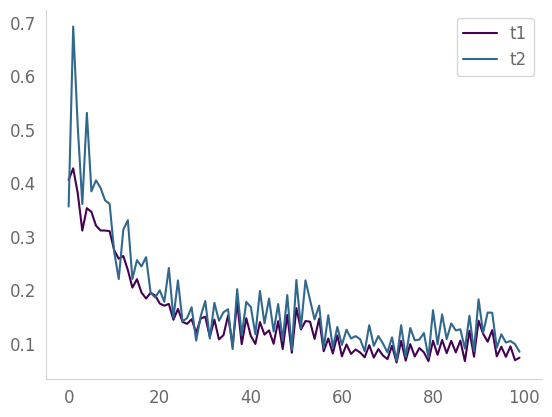

In [19]:
plt.plot(l_loss['0.0:1.0'],label = 't1')
plt.plot(l_loss['1.0:2.0'],label = 't2')
plt.legend()

### Test

In [30]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out, hold_out=args.hold_out, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.1
)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:2.4991183280944824,relative_mass_now:2.6459062281315604
RME:0.05547736290742778
Otloss:0.105214
total loss:0.105214
epoch_0_1:
relative_mass_pred:3.9003520011901855,relative_mass_now:4.0503848845346395
RME:0.03704163619544311


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

Otloss:0.106555
total loss:0.106555
New minimum otloss found: 0.10655473172664642. Model saved.


In [32]:
# generate plot data
f_net.to('cpu')
generated, trajectories,generated_weights,trajectories_weights = generate_plot_data(
    f_net, df, n_points=200, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0202, 0.0404, 0.0606, 0.0808, 0.1010, 0.1212, 0.1414, 0.1616,
        0.1818, 0.2020, 0.2222, 0.2424, 0.2626, 0.2828, 0.3030, 0.3232, 0.3434,
        0.3636, 0.3838, 0.4040, 0.4242, 0.4444, 0.4646, 0.4848, 0.5051, 0.5253,
        0.5455, 0.5657, 0.5859, 0.6061, 0.6263, 0.6465, 0.6667, 0.6869, 0.7071,
        0.7273, 0.7475, 0.7677, 0.7879, 0.8081, 0.8283, 0.8485, 0.8687, 0.8889,
        0.9091, 0.9293, 0.9495, 0.9697, 0.9899, 1.0101, 1.0303, 1.0505, 1.0707,
        1.0909, 1.1111, 1.1313, 1.1515, 1.1717, 1.1919, 1.2121, 1.2323, 1.2525,
        1.2727, 1.2929, 1.3131, 1.3333, 1.3535, 1.3737, 1.3939, 1.4141, 1.4343,
        1.4545, 1.4747, 1.4949, 1.5152, 1.5354, 1.5556, 1.5758, 1.5960, 1.6162,
        1.6364, 1.6566, 1.6768, 1.6970, 1.7172, 1.7374, 1.7576, 1.7778, 1.7980,
        1.8182, 1.8384, 1.8586, 1.8788, 1.8990, 1.9192, 1.9394, 1.9596, 1.9798,
        2.0000])
<class 'torch.Tensor'>


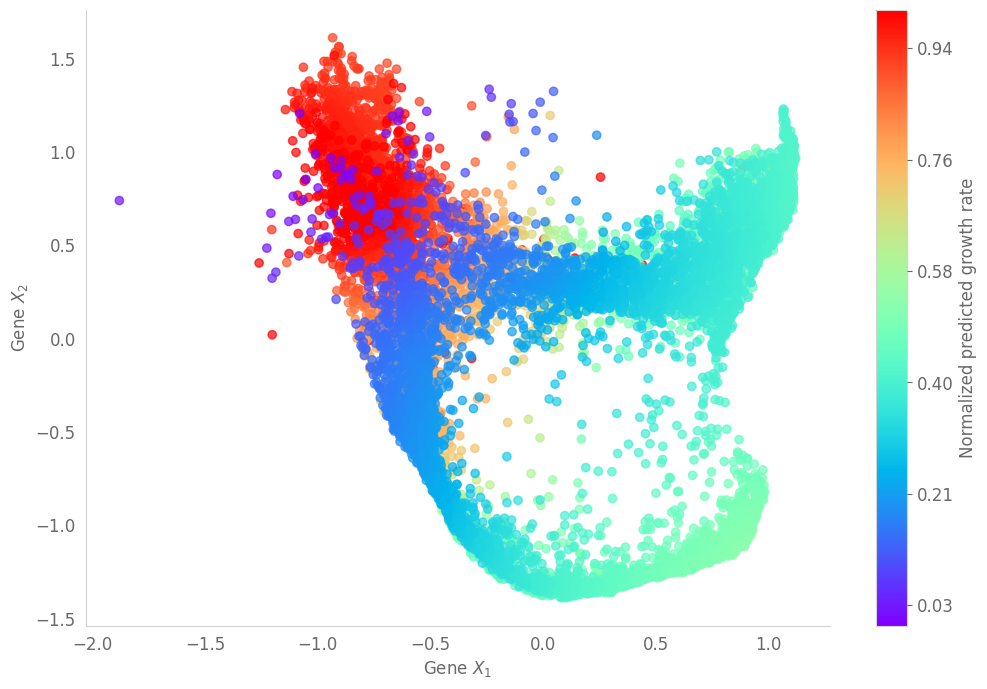

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        x = torch.tensor(subset['x1'].values, dtype=torch.float32).to(device)
        y = torch.tensor(subset['x2'].values, dtype=torch.float32).to(device)
        data = torch.stack([x, y], dim=1)
        
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 95)
    
    norm = plt.Normalize(vmin=all_g_values.min(), vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_final.pdf')

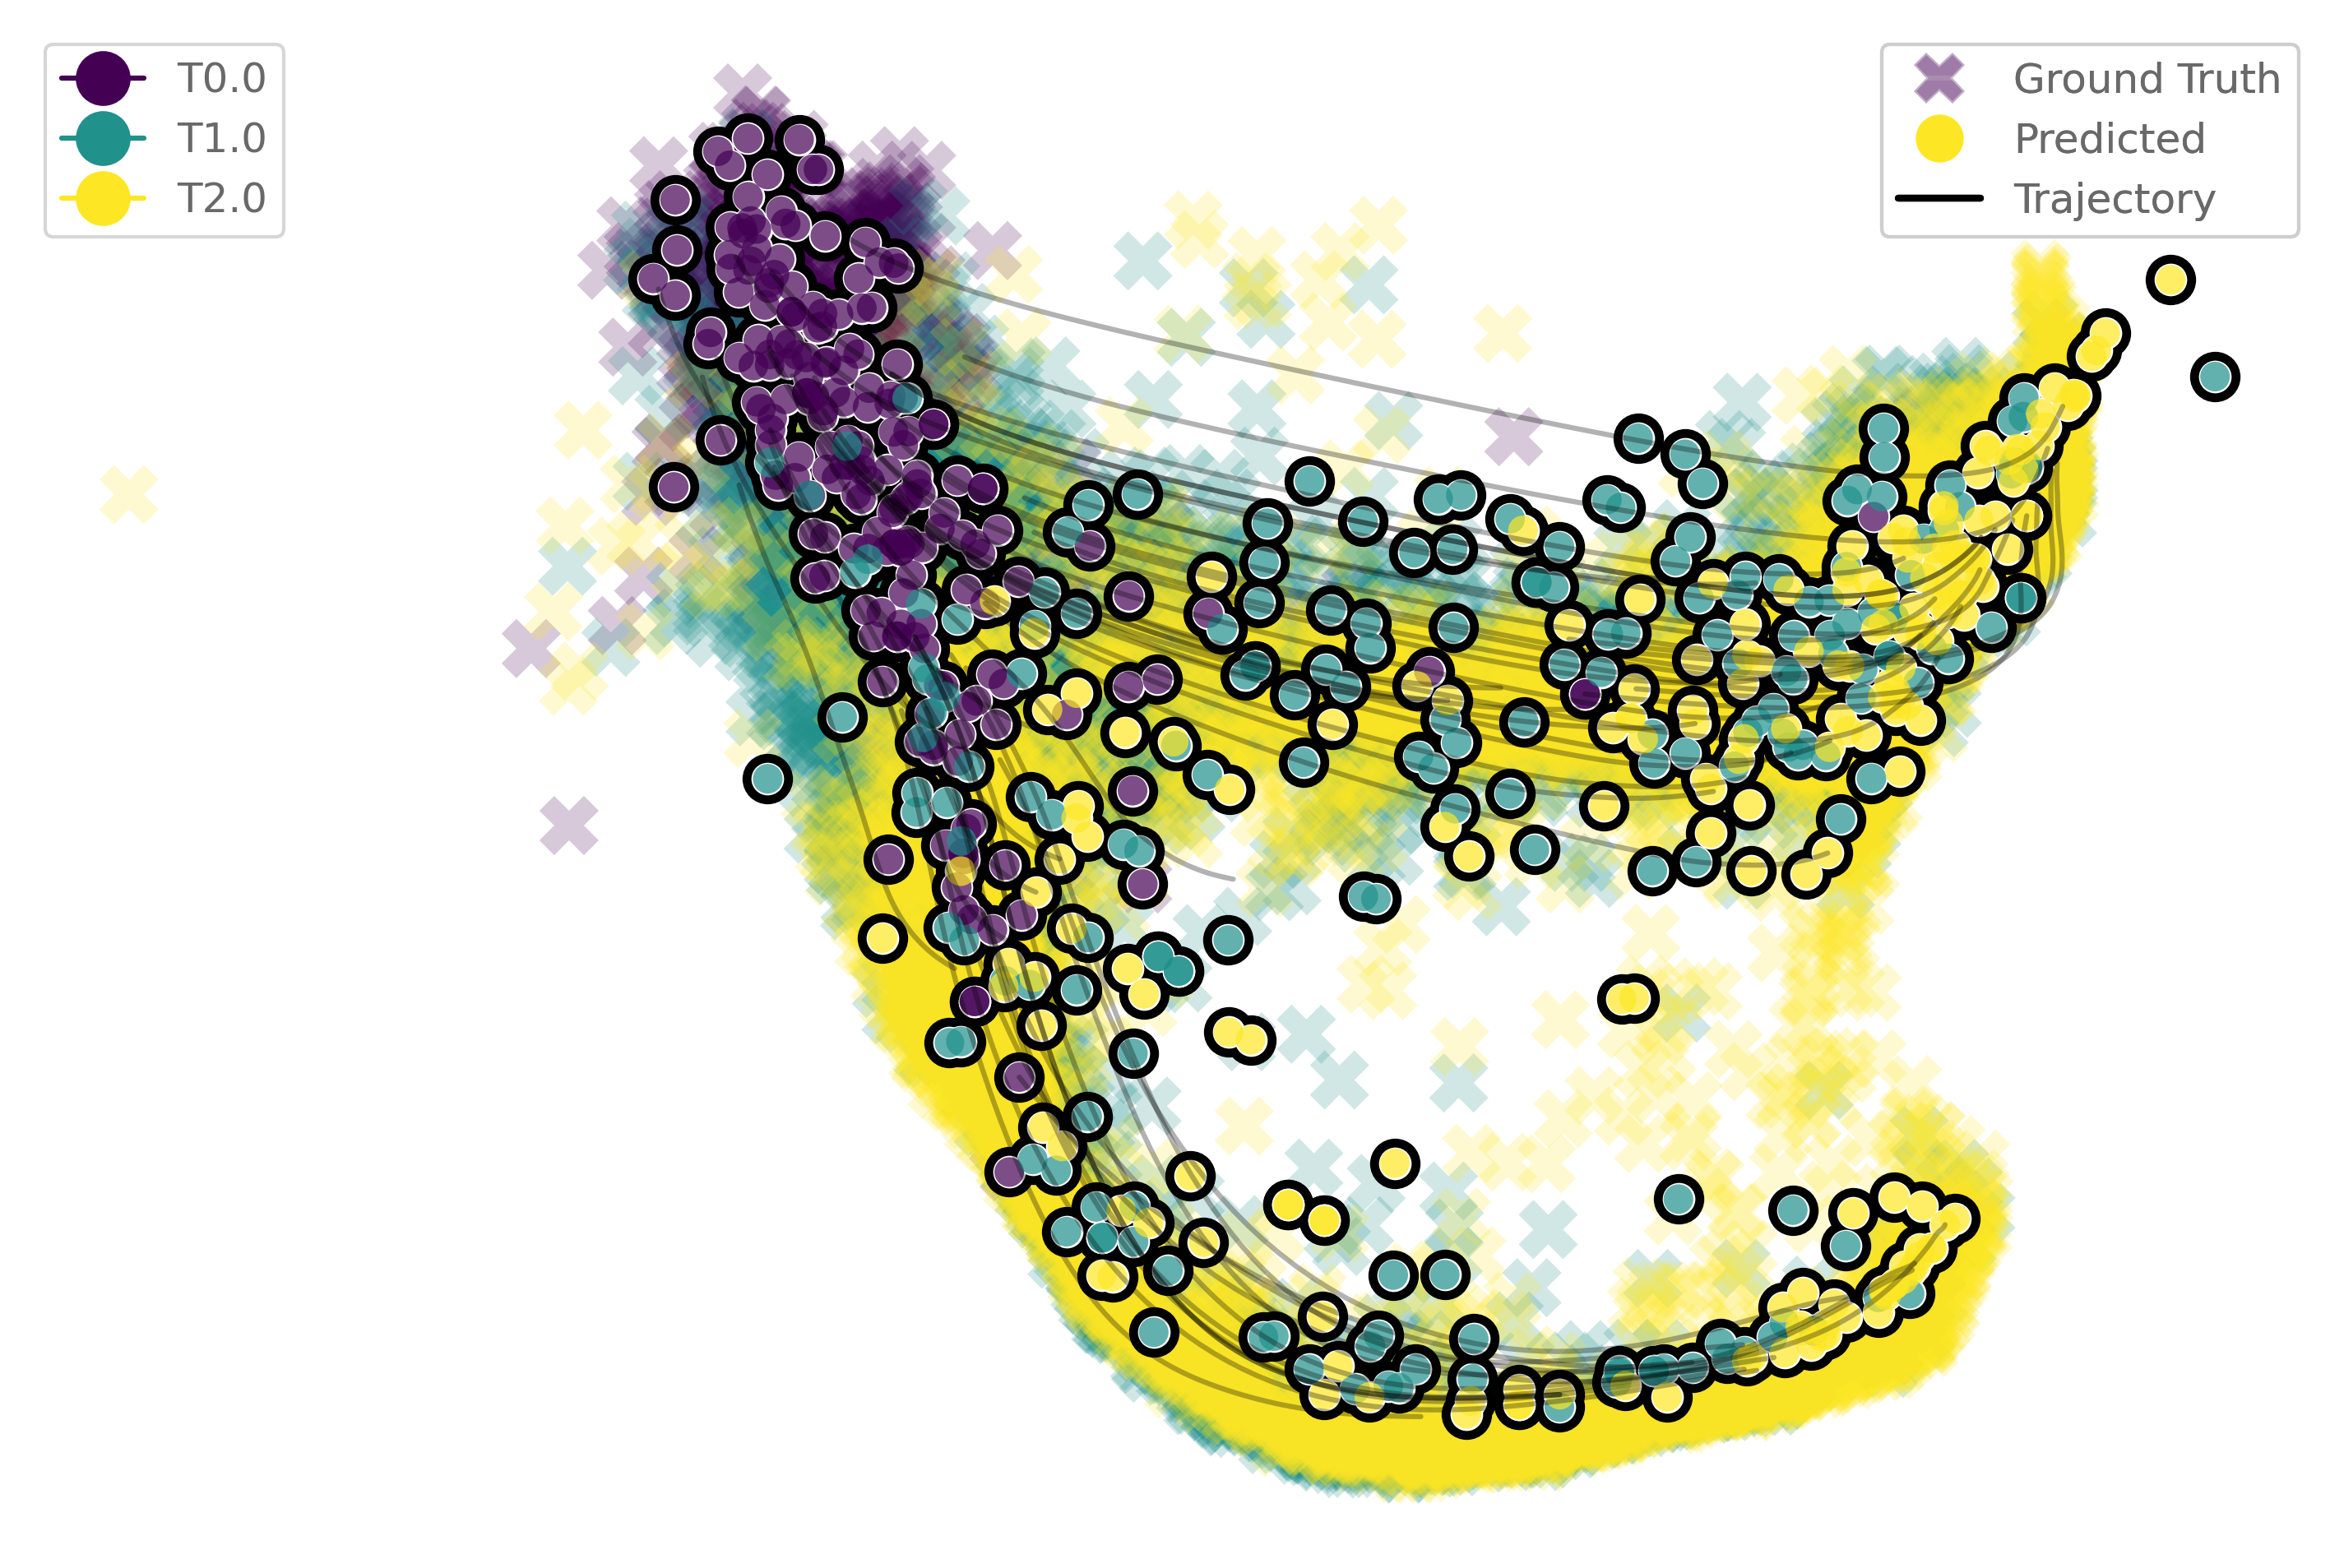

In [34]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_final.png',
    x='x1', y='x2', is_3d=False
)